# Convolutional Neural Network (1of1)

**Notes about this specific notebook**

Uses rgb, 64x64 images with ReLU activation.

# CHANGE

_____________________________________________________________________

In [142]:
# Image size (height x width)
ih = 64
iw = 64

# Grayscale or RGB
ch = 'rgb'

# Batch size
batch_size = 40000

# Number of epochs
epoch_t = 200

# Where computation is performed: Kaggle (0) or Local (1)
cenv = 1

# Division of the training vs. test set (in %)
test_size = 0.3

_____________________________________________________________________

In [143]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight
from sklearn import metrics
import sys
import os
from math import log
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [144]:
is_cuda_gpu_available = tf.config.list_physical_devices('GPU')
print(is_cuda_gpu_available)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [145]:
im_si = (ih, iw)

if(ch == 'rgb'):
    chnum = 3
elif(ch == 'grayscale'):
    chnum = 1

Create new directory for saving output files

In [146]:
if cenv == 1:
    file_exists = []
    vnum = 1
    dir = "C:/Users/Max/Documents/GitHub/cnn"
    for files in os.listdir(dir):
        if "cnn" in files:
            vnum = max(vnum, int(files[-3:]))
            new_vnum = vnum + 1
            file_exists.append(True)
        else: 
            file_exists.append(False)
    # If this is the first notebook you want to save, a new folder will be created with version #001
    if sum(file_exists) == 0:
        new_vnum = 1
        print("No matches found")

    else: 
        print(f"{sum(file_exists)} matches(es) found")
        print("--------------")

    # Print new folder name
    print(f"New folder name: cnn-local-v{new_vnum:03}")
    print("--------------")
    
    # Create new folder with the name of the notebook and the version number
    new_dir = f"/Users/Max/Documents/GitHub/cnn/cnn-local-v{new_vnum:03}"
    os.makedirs(new_dir)

3 matches(es) found
--------------
New folder name: cnn-local-v007
--------------


**Data**


In [147]:
if cenv == 0:
    path_root = "/kaggle/input/thesis-data"

if cenv == 1:
    path_root = "C:/Users/Max/Documents/thesis_data"

In [148]:
batches = ImageDataGenerator().flow_from_directory(
    directory     = path_root, 
    color_mode    = ch, 
    target_size   = (ih,iw), 
    batch_size    = batch_size,
    interpolation = 'bicubic'
)
imgs, labels = next(batches)

Found 26548 images belonging to 11 classes.


In [149]:
batches.class_indices

{'BetterSurf': 0,
 'Eksor.A': 1,
 'Obfuscator.AFQ': 2,
 'Occamy.C': 3,
 'OnLineGames.CTB': 4,
 'Reveton.A': 5,
 'Sfone': 6,
 'VB.IL': 7,
 'Zbot': 8,
 'Zbot!CI': 9,
 'benign': 10}

In [150]:
imgs.shape

(26548, 64, 64, 3)

In [151]:
labels.shape

(26548, 11)

In [152]:
test = labels[9].argmax()
print(test)

10


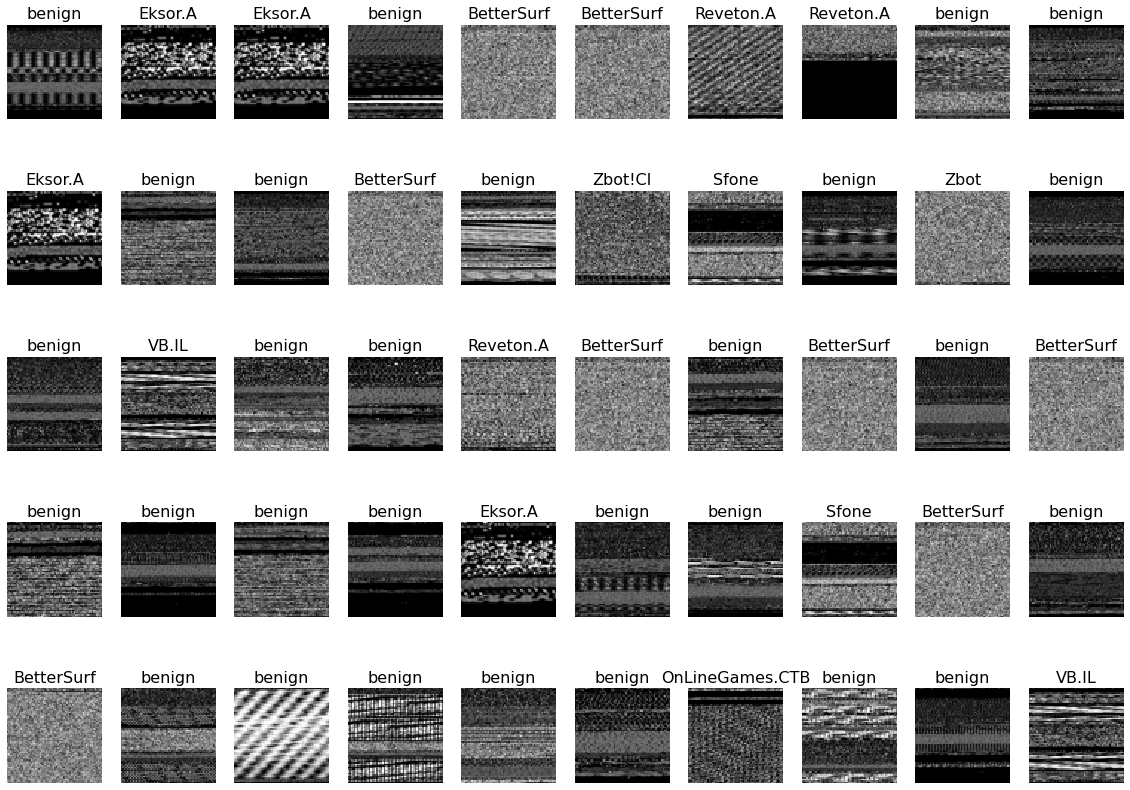

In [153]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != chnum):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], cmap = 'gray',interpolation=None if interp else 'none')
        
plots(imgs, titles = labels)

In [154]:
classes = batches.class_indices.keys()

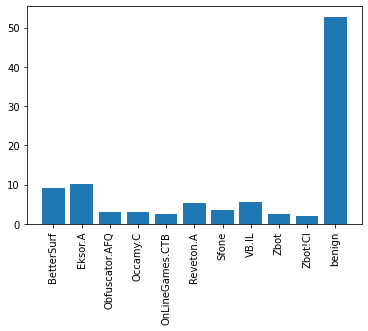

In [155]:
perc = (sum(labels)/labels.shape[0])*100
plt.xticks(rotation='vertical')
plt.bar(classes,perc)
plt.savefig(f"{new_dir}/multi_data_dist.png")

In [156]:
# Train and Test
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=test_size)
X_train.shape
X_test.shape
y_train.shape
y_test.shape

(7965, 11)

# Convolutional Neural Network
We will now build our **CNN** model using Keras. This model will have the following layers :

* **Convolutional Layer** : 30 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **Convolutional Layer** : 15 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **DropOut Layer** : Dropping 25% of neurons.
* **Flatten Layer**
* **Dense/Fully Connected Layer** : 128 Neurons, Relu activation function
* **DropOut Layer** : Dropping 50% of neurons.
* **Dense/Fully Connected Layer** : 50 Neurons, Softmax activation function
* **Dense/Fully Connected Layer** : num_class Neurons, Softmax activation function

**Input shape** : 64 * 64* 3

In [157]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

We want **11** classes

In [158]:
num_classes = 11
print("The number of classes in our dataset: ", num_classes)

The number of classes in our dataset:  11


Building the model

In [159]:
def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(30, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(ih,iw,chnum)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return Malware_model

In [160]:
Malware_model = malware_model()
Malware_model.summary() # Overview of the CNN model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 30)        840       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 30)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 15)        4065      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 15)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 15)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2940)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [ ]:
history = Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epoch_t) # The actual computation of the CNN

Epoch 1/200
581/581 [==============================] - 4s 6ms/step - loss: 0.6002 - accuracy: 0.8228 - val_loss: 0.3500 - val_accuracy: 0.8797
Epoch 2/200
581/581 [==============================] - 4s 6ms/step - loss: 0.3575 - accuracy: 0.8883 - val_loss: 0.2653 - val_accuracy: 0.9159
Epoch 3/200
581/581 [==============================] - 4s 6ms/step - loss: 0.2922 - accuracy: 0.9082 - val_loss: 0.2336 - val_accuracy: 0.9237
Epoch 4/200
581/581 [==============================] - 4s 6ms/step - loss: 0.2593 - accuracy: 0.9171 - val_loss: 0.2249 - val_accuracy: 0.9316
Epoch 5/200
581/581 [==============================] - 4s 6ms/step - loss: 0.2339 - accuracy: 0.9240 - val_loss: 0.2032 - val_accuracy: 0.9371
Epoch 6/200
581/581 [==============================] - 3s 6ms/step - loss: 0.2135 - accuracy: 0.9325 - val_loss: 0.1875 - val_accuracy: 0.9395
Epoch 7/200
581/581 [==============================] - 4s 6ms/step - loss: 0.2040 - accuracy: 0.9352 - val_loss: 0.2018 - val_accuracy: 0.9358

Epoch 58/200
581/581 [==============================] - 3s 6ms/step - loss: 0.0570 - accuracy: 0.9811 - val_loss: 0.2261 - val_accuracy: 0.9528
Epoch 59/200
581/581 [==============================] - 3s 6ms/step - loss: 0.0584 - accuracy: 0.9808 - val_loss: 0.2368 - val_accuracy: 0.9520
Epoch 60/200
581/581 [==============================] - 3s 6ms/step - loss: 0.0644 - accuracy: 0.9798 - val_loss: 0.2524 - val_accuracy: 0.9497
Epoch 61/200
581/581 [==============================] - 4s 6ms/step - loss: 0.0748 - accuracy: 0.9764 - val_loss: 0.2303 - val_accuracy: 0.9512
Epoch 62/200
581/581 [==============================] - 4s 6ms/step - loss: 0.0604 - accuracy: 0.9798 - val_loss: 0.2659 - val_accuracy: 0.9504
Epoch 63/200
581/581 [==============================] - 4s 6ms/step - loss: 0.0581 - accuracy: 0.9805 - val_loss: 0.2514 - val_accuracy: 0.9530
Epoch 64/200
581/581 [==============================] - 4s 6ms/step - loss: 0.0627 - accuracy: 0.9791 - val_loss: 0.2319 - val_accuracy:

Epoch 115/200
581/581 [==============================] - 4s 6ms/step - loss: 0.0419 - accuracy: 0.9863 - val_loss: 0.2773 - val_accuracy: 0.9512
Epoch 116/200
581/581 [==============================] - 4s 6ms/step - loss: 0.0450 - accuracy: 0.9856 - val_loss: 0.2610 - val_accuracy: 0.9500
Epoch 117/200
581/581 [==============================] - 3s 6ms/step - loss: 0.0503 - accuracy: 0.9834 - val_loss: 0.3005 - val_accuracy: 0.9502
Epoch 118/200
581/581 [==============================] - 3s 6ms/step - loss: 0.0400 - accuracy: 0.9864 - val_loss: 0.2829 - val_accuracy: 0.9497
Epoch 119/200
581/581 [==============================] - 4s 6ms/step - loss: 0.0450 - accuracy: 0.9856 - val_loss: 0.2758 - val_accuracy: 0.9513
Epoch 120/200
581/581 [==============================] - 3s 6ms/step - loss: 0.0432 - accuracy: 0.9856 - val_loss: 0.2785 - val_accuracy: 0.9510
Epoch 121/200
581/581 [==============================] - 4s 6ms/step - loss: 0.0419 - accuracy: 0.9855 - val_loss: 0.3131 - val_ac

In [ ]:
scores = Malware_model.evaluate(X_test, y_test) # Testing the CNN on the test set
print(f"Overall CNN Accuracy: {scores[1]}\n(The number of correct predictions divided by the number of total predictions)")

# Evaluating overfitting and other model performance measures

In [ ]:
def eval_metric(model, history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, epoch_t + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    if cenv == 0:
        plt.savefig("cnn_model_loss.png")
    if cenv == 1:
        plt.savefig(f"{new_dir}/cnn_model_loss.png")

In [ ]:
eval_metric(Malware_model, history, 'loss')

# Confusion Matrix
Analysing the results

In [ ]:
y_pred = np.argmax(Malware_model.predict(X_test), axis=-1)
y_pred

In [ ]:
y_test2 = np.argmax(y_test, axis=1)
y_test2

In [ ]:
c_matrix = metrics.confusion_matrix(y_test2, y_pred)
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if cenv == 0:
        plt.savefig("multi_class_cmatrix.png")
    if cenv == 1:
        plt.savefig(f"{new_dir}/multi_class_cmatrix.png")

In [ ]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)

# Detection Measurement
y_predbin and y_testbin are the binary classification arrays. 0 = ransomware and 1 = benign

In [ ]:
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
from prettytable import PrettyTable, MSWORD_FRIENDLY

In [ ]:
y_predbin = [] 
y_truebin = []
for count, value in enumerate(y_test2):
    if y_test2[count] in range(10): # range(10) is 0 to 9
        y_truebin.append(0)
    else: y_truebin.append(1)
    
    if y_pred[count] in range(10):
        y_predbin.append(0)
    else: y_predbin.append(1)
    
    continue
print(len(y_truebin))
print(len(y_predbin))

In [ ]:
binary_labels = np.array([])
for count, value in enumerate(labels):
    if labels[count].argmax() in range(10): # range(10) is 0 to 9
        binary_labels = np.append(binary_labels, "Ransomware")
    else: binary_labels = np.append(binary_labels, "Benign")
    continue
print(binary_labels)
rw_count = np.count_nonzero(binary_labels == "Ransomware")
bn_count = np.count_nonzero(binary_labels == "Benign")
print(f"Ransomware Occurences: {rw_count}, Benign Occurences: {bn_count}")

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x_lab = ['Ransomware', 'Benign']
y_lab = [rw_count, bn_count]
ax.bar(x_lab, y_lab)
if cenv == 0:
    plt.savefig("data_dist.png.png")
if cenv == 1:
    plt.savefig(f"{new_dir}/bin_data_dist.png")

In [ ]:
c_matrix_bin = metrics.confusion_matrix(y_truebin, y_predbin)
def confusion_matrix_bin(confusion_matrix, class_names_bin, figsize = (5,2), fontsize=7):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names_bin, columns=class_names_bin, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if cenv == 0:
        plt.savefig("bin_class_cmatrix.png")
    if cenv == 1:
        plt.savefig(f"{new_dir}/bin_class_cmatrix.png")

In [ ]:
class_names_bin= ("ransomware", "benign")
confusion_matrix_bin(c_matrix_bin, class_names_bin, figsize = (5,2), fontsize=10)

**True Positive Rate**

In [ ]:
TPR = c_matrix_bin[0,0]/(c_matrix_bin[0,0] + c_matrix_bin[0,1]) #True Positive Rate

**Accuracy**

In [ ]:
ACC = accuracy_score(y_truebin, y_predbin) # Accuracy

**F1 Score**

In [ ]:
F1 = f1_score(y_truebin, y_predbin, labels=0) # F1 Score

**Matthews Correlation Coefficient**

In [ ]:
MCC = matthews_corrcoef(y_truebin, y_predbin) # Matthews Correlation Coefficient

**Show Performance of CNN**

In [ ]:
t = PrettyTable(['Metric', 'Performance'])
t.add_row(['True Positive Rate', round(TPR,4)])
t.add_row(['Accuracy', round(ACC,4)])
t.add_row(['F1 Score', round(F1,4)])
t.add_row(['Matthews Correlation Coefficient', round(MCC,4)])
t.header = True
t.align = "l"
t.title = "Performance of CNN"
print(t)

In [ ]:
# Saving PrettyTable
table = t.get_string()

if cenv == 0:
    with open('bin_performance_table.txt', 'w') as f:
        f.write(table)
if cenv == 1:
    with open(f'{new_dir}/bin_performance_table.txt', 'w') as f:
        f.write(table)
